<a href="https://colab.research.google.com/github/Kim-ahhyeon/Computer-Vision/blob/main/2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 컴퓨터비전 과제 [HW#2]
# 2025.04.13
# 2022041010 김아현

In [2]:
# 컴퓨터비전 과제 [HW#2]
# 2025.04.13
# 2022041010 김아현

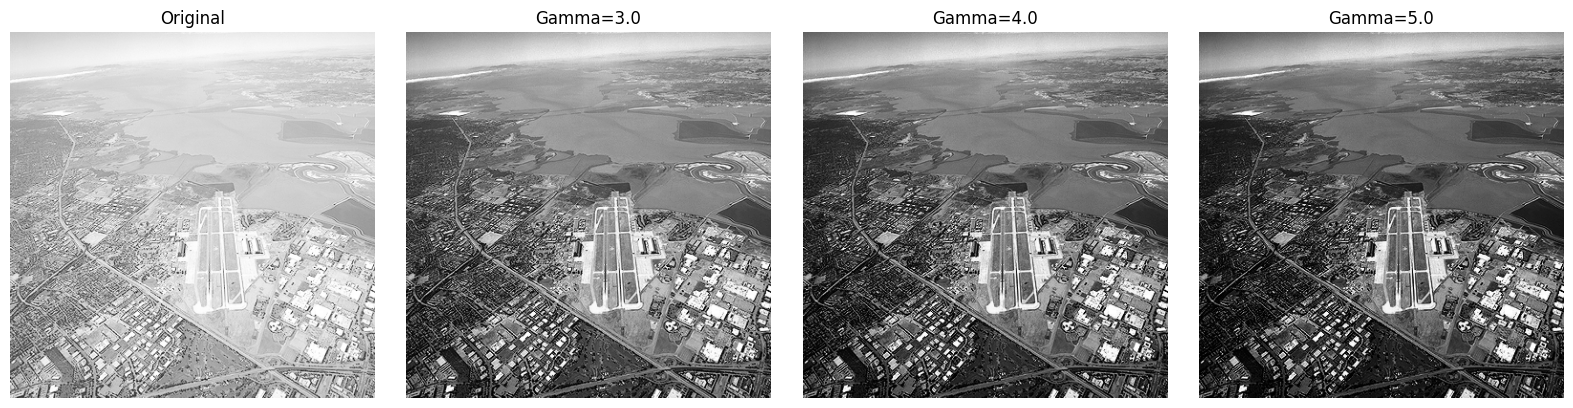

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# 이미지 URL
img_url = "https://github.com/kjcheoi-class/CV/raw/main/Fig0309(a)(washed_out_aerial_image).tif"

# 웹에서 이미지 다운로드
response = requests.get(img_url)
if response.status_code != 200:
    raise Exception("이미지를 불러올 수 없다")

# 이미지를 메모리에서 읽기
img_array = np.frombuffer(response.content, np.uint8)
img = cv.imdecode(img_array, cv.IMREAD_GRAYSCALE)

# 이미지 크기 축소 (절반 크기로 축소)
img = cv.resize(img, (img.shape[1] // 2, img.shape[0] // 2))

# 감마 변환 함수 - 감마 값이 크면 이미지가 어두워지고, 작아지면 밝아진다.
def power_law_transform(img, c=1, gamma=1.0):
    f1 = img / 255.0
    out = c * (f1 ** gamma)
    return np.uint8(np.clip(out * 255, 0, 255))  # 다시 [0,255]로 확장 및 변환

# 각각 감마 값에 따른 이미지 변환
img1 = power_law_transform(img, c=1, gamma=3.0)
img2 = power_law_transform(img, c=1, gamma=4.0)
img3 = power_law_transform(img, c=1, gamma=5.0)

# 결과 이미지 시각화
titles = ['Original', 'Gamma=3.0', 'Gamma=4.0', 'Gamma=5.0']
images = [img, img1, img2, img3]

plt.figure(figsize=(16, 4))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


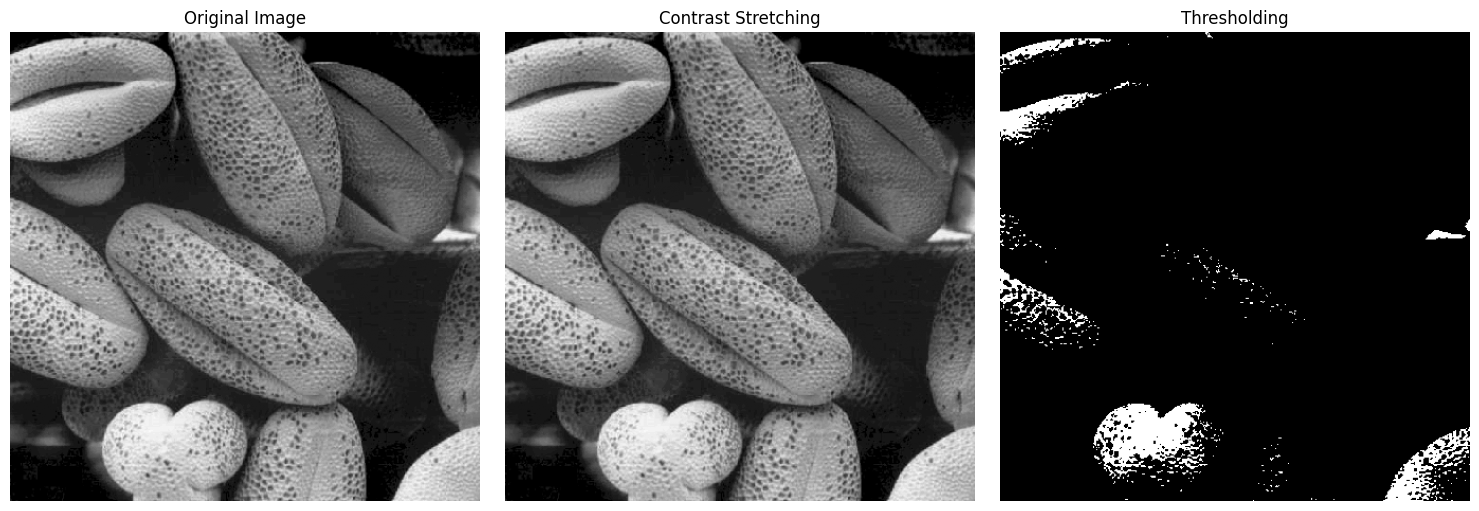

In [4]:
# HW 2-2 #
# Piecewise-Linear Transformation

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# 이미지 URL
img_url = "https://github.com/kjcheoi-class/CV/raw/main/Fig0310(b)(washed_out_pollen_image).tif"

# 웹에서 이미지 다운로드
response = requests.get(img_url)
if response.status_code != 200:
    raise Exception("이미지를 불러올 수 없다")

# 이미지를 메모리에서 읽기
img_array = np.frombuffer(response.content, np.uint8)
img = cv.imdecode(img_array, cv.IMREAD_COLOR)  # 컬러로 읽기

# 이미지 크기 축소 (절반 크기로 축소)
img = cv.resize(img, (img.shape[1] // 2, img.shape[0] // 2))

# 이미지를 그레이스케일로 변환
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# contrast_stretching 함수 - 이미지 대비를 확대해 밝은 부분과 어두운 부분의 구분을 명확하게 만든다.
def contrast_stretching(img):
    min_val = np.min(img)
    max_val = np.max(img)
    stretched = (img - min_val) / (max_val - min_val) * 255
    return np.uint8(np.clip(stretched, 0, 255))

# 임계값 처리 함수 - 이미지의 픽셀 값을 특정 임계값을 기준으로 이진화한다.
def thresholding(img, threshold=128):
    _, thresh_img = cv.threshold(img, threshold, 255, cv.THRESH_BINARY)
    return thresh_img

# 처리한 이미지 각각 저장
stretched_img = contrast_stretching(img_gray)
threshold_img = thresholding(img_gray, threshold=128)

# 결과 이미지 시각화
titles = ['Original Image', 'Contrast Stretching', 'Thresholding']
images = [img_gray, stretched_img, threshold_img]

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    # 모든 이미지를 흑백으로 표시
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

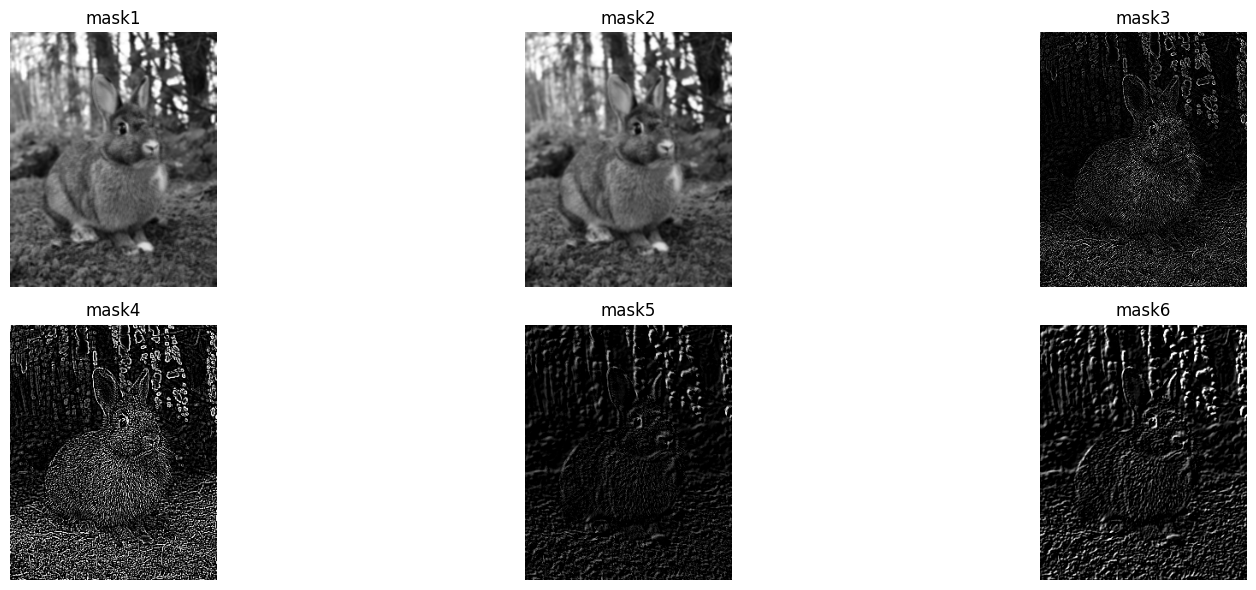

In [5]:
# HW 2-3 #
# 마스크를 사용해 컨볼루션

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# 이미지 URL (raw=true를 추가하여 이미지를 직접 다운로드)
img_url = "https://github.com/kjcheoi-class/CV/raw/main/rabbit.jpg"

# 웹에서 이미지 다운로드
response = requests.get(img_url)
if response.status_code != 200:
    raise Exception("이미지를 불러올 수 없다")

# 이미지를 메모리에서 읽기
img_array = np.frombuffer(response.content, np.uint8)
img = cv.imdecode(img_array, cv.IMREAD_GRAYSCALE)

# 이미지 크기 축소 (절반 크기로 축소)
img = cv.resize(img, (img.shape[1] // 2, img.shape[0] // 2))

# 총 6개의 마스크를 정의한다
kernels = [
    np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]], dtype=np.float32) / 9,  # 박스 필터
    np.array([[0.0030, 0.0133, 0.0219, 0.0133, 0.0030], [0.0133, 0.0596, 0.0983, 0.0596, 0.0133], # 가우시안 필터, 5X5
     [0.0219, 0.0983, 0.1621, 0.0983, 0.0219], [0.0133, 0.0596, 0.0983, 0.0596, 0.0133],
      [0.0030, 0.0133, 0.0219, 0.0133, 0.0030]], dtype=np.float32),
    np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=np.float32),  # 라플라시안 필터
    np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=np.float32),  # 소벨 필터
    np.array([[-1, 0, 0], [0, 0, 0], [0, 0, 1]], dtype=np.float32),
    np.array([[-1, -1, 0], [-1, 0, 1], [0, 1, 1]], dtype=np.float32),
]

# 각 커널에 대해 이미지 컨볼루션 수행
convolved_images = [cv.filter2D(img, -1, kernel) for kernel in kernels]

# 결과 이미지 시각화
titles = ['mask1', 'mask2', 'mask3', 'mask4', 'mask5', 'mask6']
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(convolved_images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


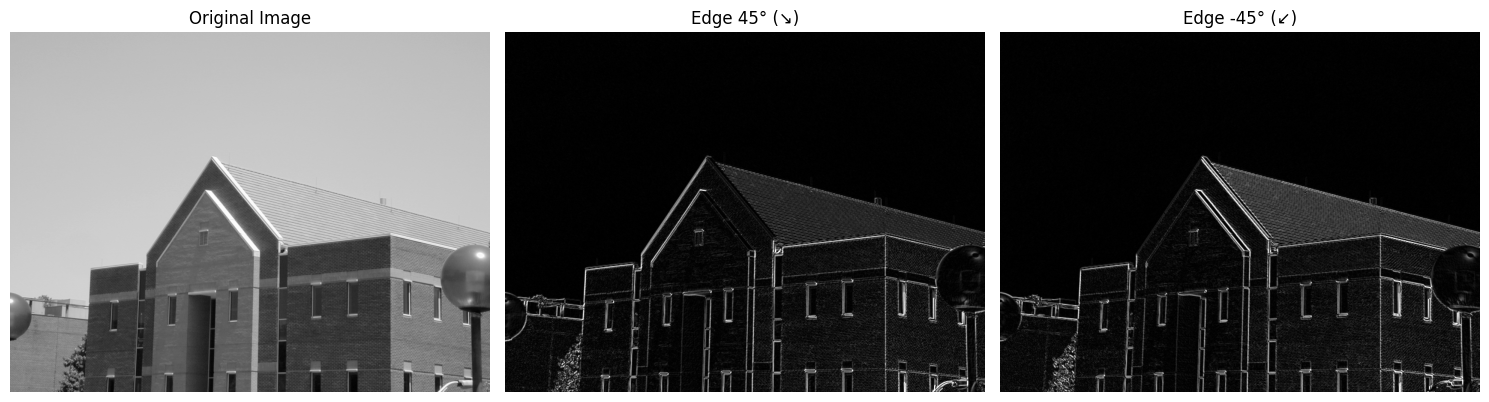

In [6]:
# HW 2-4 #
# 대각선 edge 검출

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# 이미지 URL (raw=true를 추가하여 이미지를 직접 다운로드)
img_url = "https://github.com/kjcheoi-class/CV/raw/main/school.jpg"

# 웹에서 이미지 다운로드
response = requests.get(img_url)
if response.status_code != 200:
    raise Exception("이미지를 불러올 수 없다")

# 이미지를 메모리에서 읽기
img_array = np.frombuffer(response.content, np.uint8)
img = cv.imdecode(img_array, cv.IMREAD_GRAYSCALE)

# 이미지 크기 축소 (절반 크기로 축소)
img = cv.resize(img, (img.shape[1] // 2, img.shape[0] // 2))

# kernel_45는 45도 방향 대각선 edge 검출
kernel_45 = np.array([
    [-1, -1,  0],
    [-1,  0,  1],
    [ 0,  1,  1]
], dtype=np.float32)

# kernel_neg45는 -45도 방향 대각선 edge 검출
kernel_neg45 = np.array([
    [ 0,  1,  1],
    [-1,  0,  1],
    [-1, -1,  0]
], dtype=np.float32)

# 이미지를 커널과 컨볼루션해 필터링을 수행한다
edge_45 = cv.filter2D(img, cv.CV_64F, kernel_45)
edge_neg45 = cv.filter2D(img, cv.CV_64F, kernel_neg45)

# 절댓값을 취하고 0~255 범위로 정규화한다
edge_45 = cv.convertScaleAbs(edge_45)
edge_neg45 = cv.convertScaleAbs(edge_neg45)

# 결과 이미지 시각화
titles = ['Original Image', 'Edge 45° (↘)', 'Edge -45° (↙)']
images = [img, edge_45, edge_neg45]

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


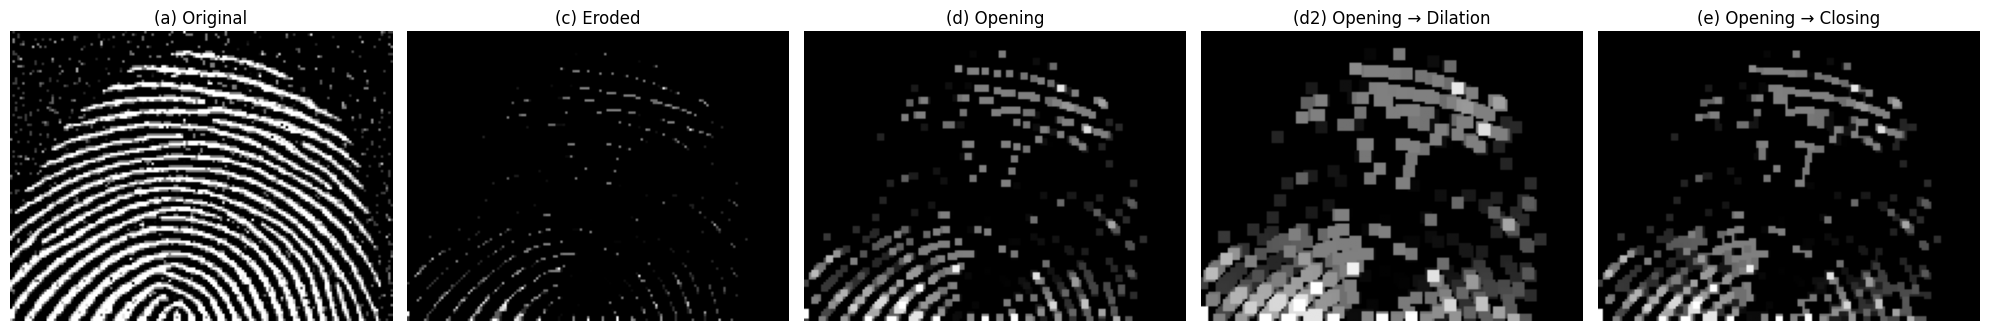

In [7]:
# HW 2-5 #
# 지문영상 개선

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# 이미지 URL (raw=true를 추가하여 이미지를 직접 다운로드)
img_url = "https://github.com/kjcheoi-class/CV/raw/main/finger.jpg"

# 웹에서 이미지 다운로드
response = requests.get(img_url)
if response.status_code != 200:
    raise Exception("이미지를 불러올 수 없다")

# 이미지를 메모리에서 읽기
img_array = np.frombuffer(response.content, np.uint8)
img = cv.imdecode(img_array, cv.IMREAD_GRAYSCALE)

# 이미지 크기 축소 (절반 크기로 축소)
img = cv.resize(img, (img.shape[1] // 2, img.shape[0] // 2))

# 커널 정의
kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))

# 침식(Erosion) (c)
# 이미지의 객체를 줄이고 축소
eroded = cv.erode(img, kernel, iterations=1)

# 열림(Opening) (d)
# 침식 후 팽창
opened = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)

# 열림(Opening) → 팽창(Dilation) (d2)
opened_dilated = cv.dilate(opened, kernel, iterations=1)

# 열림(Opening) → 닫힘(Closing) (e)
opened_closed = cv.morphologyEx(opened, cv.MORPH_CLOSE, kernel)

# 결과 이미지셋 시각화
titles = ['(a) Original', '(c) Eroded', '(d) Opening',
          '(d2) Opening → Dilation', '(e) Opening → Closing']
images = [img, eroded, opened, opened_dilated, opened_closed]

plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


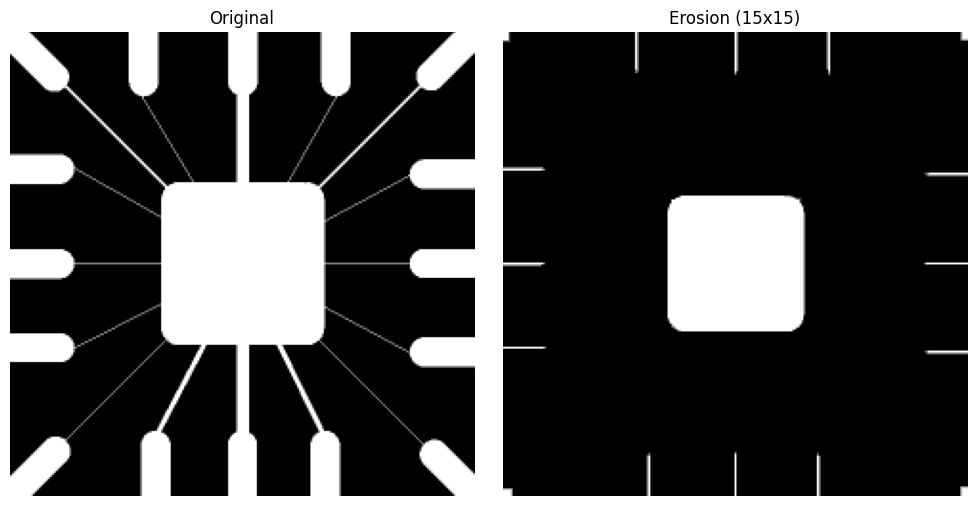

In [8]:
# HW 2-6 #
# 침식 연산

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# 이미지 URL (raw=true를 추가하여 이미지를 직접 다운로드)
img_url = "https://github.com/kjcheoi-class/CV/raw/main/Fig0905(a)(wirebond-mask).tif"

# 웹에서 이미지 다운로드
response = requests.get(img_url)
if response.status_code != 200:
    raise Exception("이미지를 불러올 수 없다")

# 이미지를 메모리에서 읽기
img_array = np.frombuffer(response.content, np.uint8)
img = cv.imdecode(img_array, cv.IMREAD_GRAYSCALE)

# 이미지 크기 축소 (절반 크기로 축소)
img = cv.resize(img, (img.shape[1] // 2, img.shape[0] // 2))

# 15X15 정사각형 구조요소
kernel = np.ones((15, 15), np.uint8)

# 침식 연산을 1번 반복한다
# 이미지에서 밝은 부분을 축소시키고 어두운 부분을 확장시킨다
eroded = cv.erode(img, kernel, iterations=1)

# 1행 2열 서브플롯 생성
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(eroded, cmap='gray')
plt.title("Erosion (15x15)")
plt.axis('off')

plt.tight_layout()
plt.show()


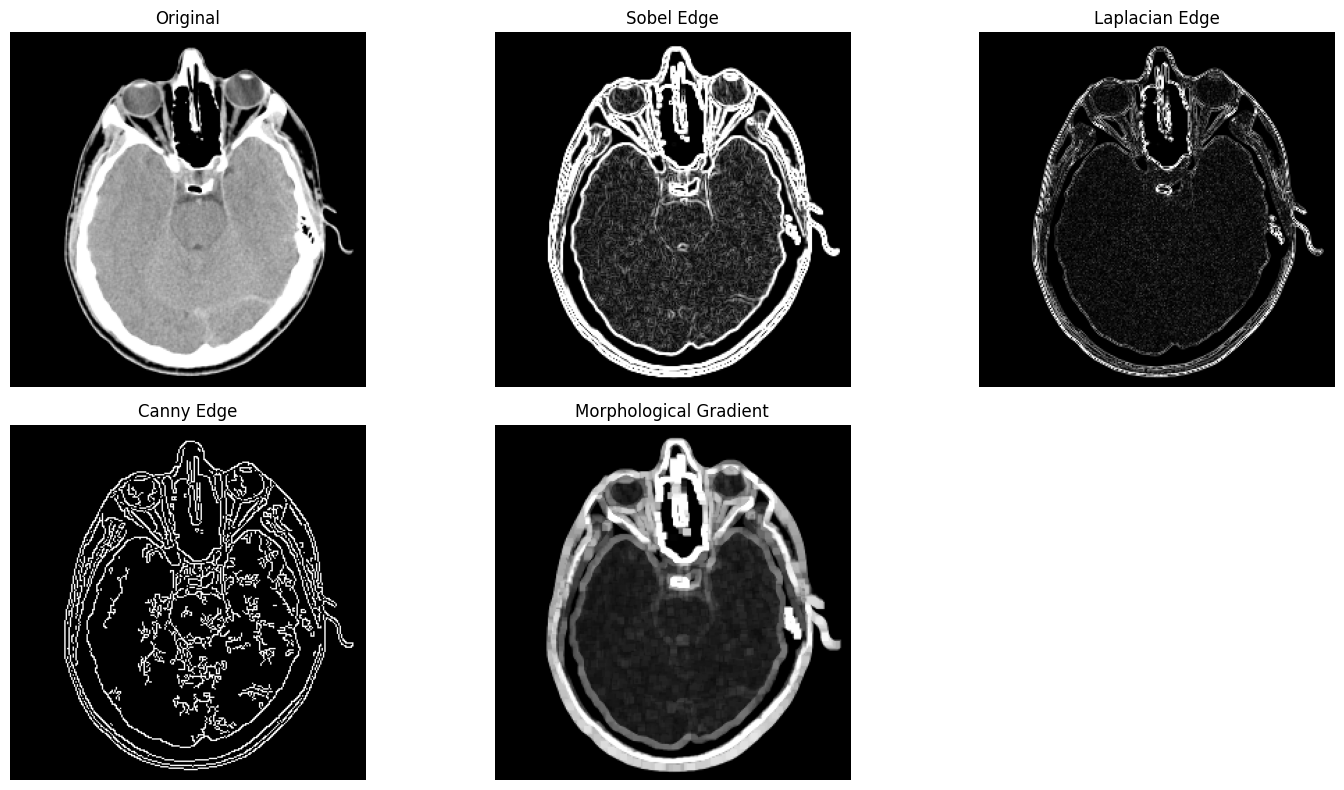

In [9]:
# HW 2-7 #
# 엣지 검출 알고리즘

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# 이미지 URL (raw=true를 추가하여 이미지를 직접 다운로드)
img_url = "https://github.com/kjcheoi-class/CV/raw/main/Fig0939(a)(headCT-Vandy).tif"

# 웹에서 이미지 다운로드
response = requests.get(img_url)
if response.status_code != 200:
    raise Exception("이미지를 불러올 수 없다")

# 이미지를 메모리에서 읽기
img_array = np.frombuffer(response.content, np.uint8)
img = cv.imdecode(img_array, cv.IMREAD_GRAYSCALE)

# 이미지 크기 축소 (절반 크기로 축소)
img = cv.resize(img, (img.shape[1] // 2, img.shape[0] // 2))

# 1 - Sobel 엣지
# 이미지의 밝기 변화율을 계산해 경계를 검출한다
# x방향과 y방향의 변화율을 구하고, 두 벡터의 크기를 계산해서 최종 엣지를 생성한다
sobelx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=3)
sobely = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=3)
sobel_edge = cv.magnitude(sobelx, sobely)
sobel_edge = cv.convertScaleAbs(sobel_edge)

# 2 - Laplacian 엣지
# 2차 미분을 활용해 엣지를 검출한다
# 방향(x,y)를 고려하지 않는다
laplacian_edge = cv.Laplacian(img, cv.CV_64F)
laplacian_edge = cv.convertScaleAbs(laplacian_edge)

# 3 - Canny 엣지
# 가장 정밀하고 노이즈에 강하다
# threshold1은 약한 엣지를 위한 임계값, threshold2는 강한 엣지를 위한 임계값이다
canny_edge = cv.Canny(img, threshold1=50, threshold2=150)

# 4 - Morphological Gradient
# 팽창->침식 연산을 수행하고 두 값의 차이를 계산해 엣지를 검출한다
# 이미지의 경계 부분만 강조한다
kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))
dilated = cv.dilate(img, kernel)
eroded = cv.erode(img, kernel)
morph_gradient = cv.absdiff(dilated, eroded)

# 결과 이미지 시각화
titles = ['Original', 'Sobel Edge', 'Laplacian Edge', 'Canny Edge', 'Morphological Gradient']
images = [img, sobel_edge, laplacian_edge, canny_edge, morph_gradient]

plt.figure(figsize=(15, 8))
for i in range(5):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

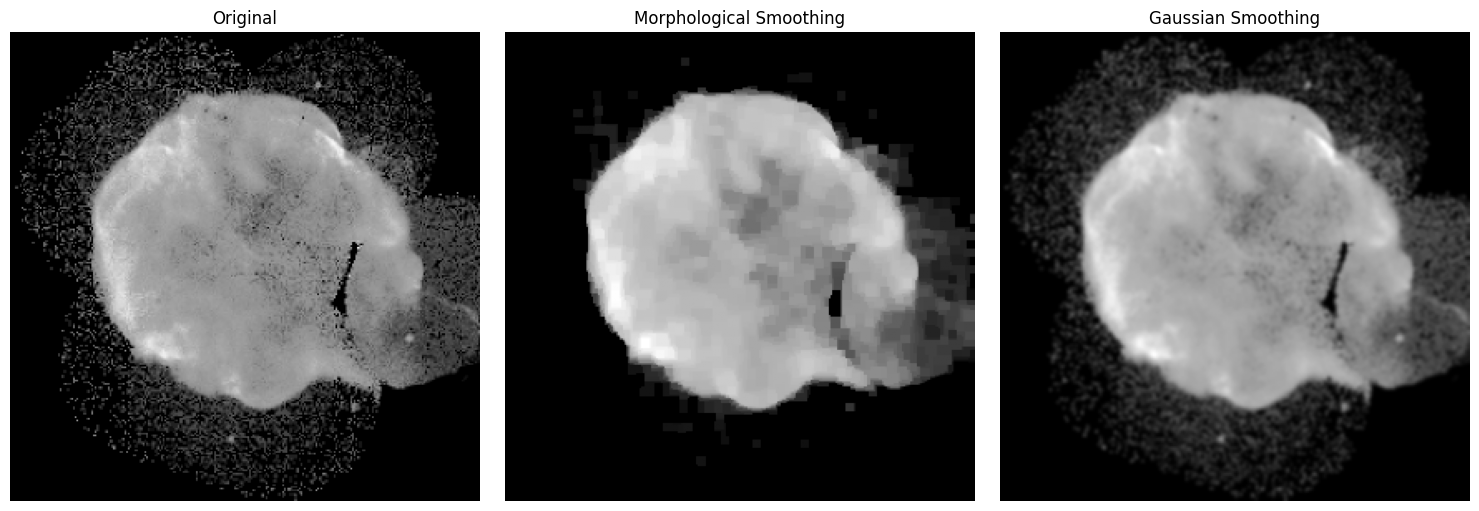

In [10]:
# HW 2-8 #
# 노이즈 영역 지우기

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# 이미지 URL (raw=true를 추가하여 이미지를 직접 다운로드)
img_url = "https://github.com/kjcheoi-class/CV/raw/main/Fig0938(a)(cygnusloop_Xray_original).tif"

# 웹에서 이미지 다운로드
response = requests.get(img_url)
if response.status_code != 200:
    raise Exception("이미지를 불러올 수 없다")

# 이미지를 메모리에서 읽기
img_array = np.frombuffer(response.content, np.uint8)
img = cv.imdecode(img_array, cv.IMREAD_GRAYSCALE)

# 이미지 크기 축소 (절반 크기로 축소)
img = cv.resize(img, (img.shape[1] // 2, img.shape[0] // 2))

# 1 - Morphological Smoothing
# Opening -> Closing
# 밝고 어두운 노이즈를 동시에 제거한다
kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))
morph_open = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
morph_smooth = cv.morphologyEx(morph_open, cv.MORPH_CLOSE, kernel)

# 2 - Smoothing Filter
# 인접한 픽셀들을 가중 평균
# 경계선까지 흐려진다
gaussian_blur = cv.GaussianBlur(img, (5, 5), sigmaX=0)

# 결과 이미지 시각화
titles = ['Original', 'Morphological Smoothing', 'Gaussian Smoothing']
images = [img, morph_smooth, gaussian_blur]

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

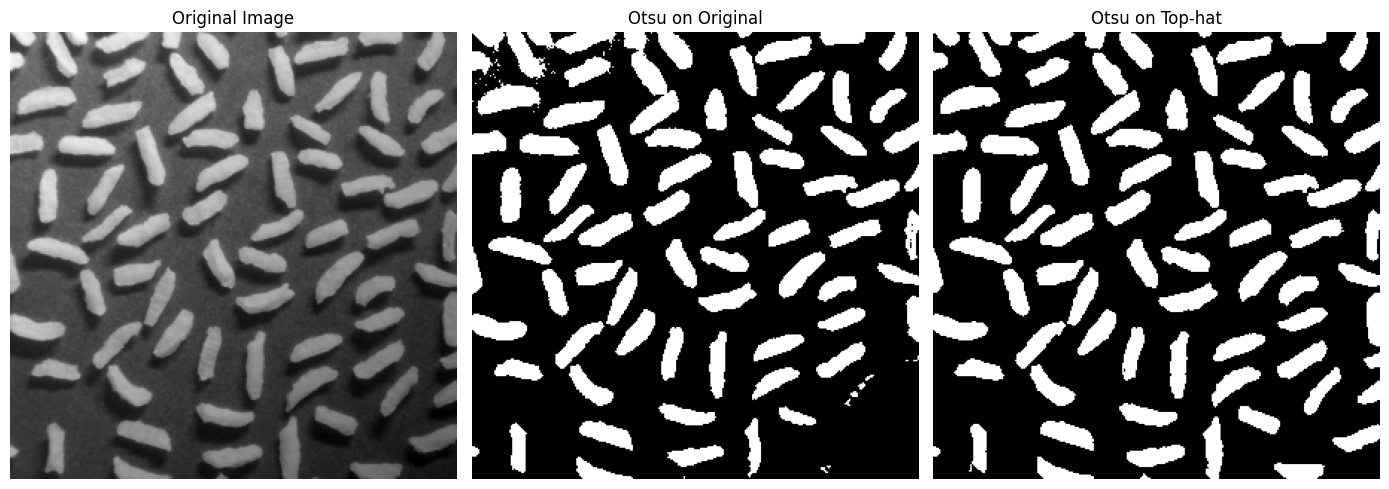

In [11]:
# HW 2-9 #
# 영상 이진화

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# 이미지 URL (raw=true를 추가하여 이미지를 직접 다운로드)
img_url = "https://github.com/kjcheoi-class/CV/raw/main/Fig0940(a)(rice_image_with_intensity_gradient).tif"

# 웹에서 이미지 다운로드
response = requests.get(img_url)
if response.status_code != 200:
    raise Exception("이미지를 불러올 수 없다")

# 이미지를 메모리에서 읽기
img_array = np.frombuffer(response.content, np.uint8)
img = cv.imdecode(img_array, cv.IMREAD_GRAYSCALE)

# 이미지 크기 축소 (절반 크기로 축소)
img = cv.resize(img, (img.shape[1] // 2, img.shape[0] // 2))

# 40X40 크기의 사각형 커널 정의
kernel = cv.getStructuringElement(cv.MORPH_RECT, (40, 40))

# 원본 이미지에 Otsu 이진화
# 전체 밝기 히스토그램만 보고 자동으로 임계값을 정해 이진화한다
_, otsu_orig = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Top-hat 변환
# 원본 이미지 - Opening
# 배경 요소를 제거하고 밝은 부분만 추출한다
tophat = cv.morphologyEx(img, cv.MORPH_TOPHAT, kernel)

# Top-hat 변환 결과에 대해 Otsu 이진화
# 배경이 제거되었으므로 더 정교하게 쌀알과 배경이 분리된다
_, otsu_tophat = cv.threshold(tophat, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# 결과 이미지 시각화
titles = ['Original Image', "Otsu on Original", "Otsu on Top-hat"]
images = [img, otsu_orig, otsu_tophat]

plt.figure(figsize=(14, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

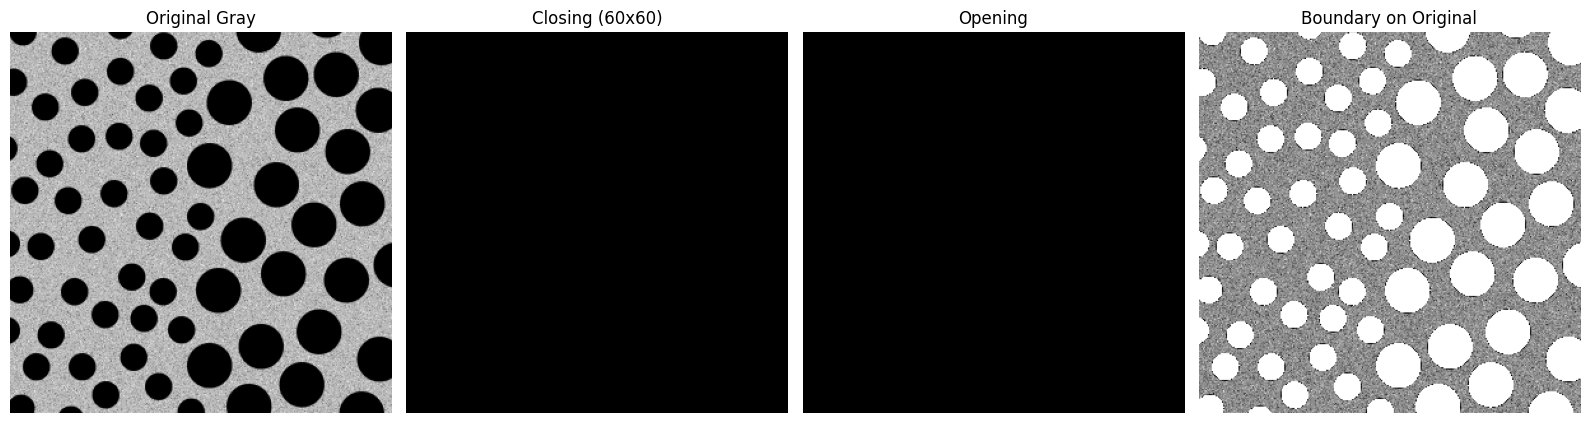

In [12]:
# HW 2-10 #
# Morphology를 적용한 분할

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# 이미지 URL (raw=true를 추가하여 이미지를 직접 다운로드)
img_url = "https://github.com/kjcheoi-class/CV/raw/main/Fig0943(a)(dark_blobs_on_light_background).tif"
# 웹에서 이미지 다운로드
response = requests.get(img_url)
if response.status_code != 200:
    raise Exception("이미지를 불러올 수 없다")

# 이미지를 메모리에서 읽기
img_array = np.frombuffer(response.content, np.uint8)
img = cv.imdecode(img_array, cv.IMREAD_GRAYSCALE)

# 이미지 크기 축소 (절반 크기로 축소)
img = cv.resize(img, (img.shape[1] // 2, img.shape[0] // 2))

# 이진화 (Otsu)
# 자동으로 최적의 이진화 임계값을 선택하여 이미지를 이진화
_, binary = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Closing 연산
# 크기 60x60 구조요소 생성, 닫힘 연산 적용
kernel_close = cv.getStructuringElement(cv.MORPH_ELLIPSE, (60, 60))
closed = cv.morphologyEx(binary, cv.MORPH_CLOSE, kernel_close)

# Opening 연산
# 크기 110X110 구조요소 생성, 열림 연산 적용
kernel_open = cv.getStructuringElement(cv.MORPH_ELLIPSE, (110, 110))
opened = cv.morphologyEx(closed, cv.MORPH_OPEN, kernel_open)

# 경계선 추출
# 원본 이미지와 열린 이미지 차이 계산
boundary = cv.absdiff(binary, opened)

# 경계선만 흰색으로 덧씌운 새로운 이미지를 생성한다
img_with_boundary = img.copy()
img_with_boundary[boundary == 255] = 255

# 결과 이미지 시각화
titles = ['Original Gray', 'Closing (60x60)', 'Opening', 'Boundary on Original']
images = [img, closed, opened, img_with_boundary]

plt.figure(figsize=(16, 5))
for i in range(len(images)):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()